Ben Ghertner 2025

Code to fetch HRRR data and load idealized background made in CM1 from a .nc file. Generates plot of HRRR data and idealized background.

    - figure 3.2

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from herbie import Herbie
import pandas as pd

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
mpl.rcParams["font.size"] = 11

%matplotlib inline

#False to fetch HRRR data then write .csv
#True to load HRRR data from .csv file (to save time)
read_HRRR = True

In [ ]:
# Constants
Rd = 287.04
Rv = 461.5
cpd = 1005.7
cpv = 1870
cpl = 4190.0
g = 9.81

p00 = 1e5

#Helpful functions

#Kirchoff's approximation for the latent heat of vapourization
lv = lambda T: 2501000.0 + (cpl-cpv)*(273.15 - T)

#r* function as in CM1
def rslf(p,T,ptype=1):
    if ptype==4:
        return 380.00*np.exp(17.2693882-4097.8531/(T-35.86))/p
    else:
        estar = 611.2 * np.exp( 17.67 * ( T  - 273.15 ) / ( T  - 29.65 ) )
        return Rd/Rv*estar/(p-estar)

In [3]:
#Open Idealized background generated in CM1
ds = xr.open_dataset("./cm1Background/cm1base.nc")
ds

/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_47564/3084561234.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset("./cm1Background/cm1base.nc")


<xarray.Dataset> Size: 72kB
Dimensions:  (one: 1, time: 1, xh: 1, xf: 2, yh: 1, yf: 2, zh: 1500, zf: 1501)
Coordinates:
  * time     (time) timedelta64[ns] 8B 00:00:00
  * xh       (xh) float32 4B 0.0
  * xf       (xf) float32 8B -12.5 12.5
  * yh       (yh) float32 4B 0.0
  * yf       (yf) float32 8B -50.0 50.0
  * zh       (zh) float32 6kB 0.5 1.5 2.5 3.5 ... 1.498e+03 1.498e+03 1.5e+03
  * zf       (zf) float32 6kB 0.0 1.0 2.0 3.0 ... 1.498e+03 1.499e+03 1.5e+03
Dimensions without coordinates: one
Data variables:
    ztop     (one) float32 4B ...
    th       (time, zh, yh, xh) float32 6kB ...
    prs      (time, zh, yh, xh) float32 6kB ...
    qv       (time, zh, yh, xh) float32 6kB ...
    ql       (time, zh, yh, xh) float32 6kB ...
    u        (time, zh, yh, xf) float32 12kB ...
    v        (time, zh, yf, xh) float32 12kB ...
    w        (time, zf, yh, xh) float32 6kB ...
    nm       (time, zf, yh, xh) float32 6kB ...
Attributes: (12/71)
    CM1 version:    cm1r21.1
    Conventions:    CF-1.7
    missing_value:  -999999.9
    x_units:        meters
    x_label:        x
    y_units:        meters
    ...             ...
    cgt1:           1.875
    cgt2:           -1.25
    cgt3:           0.375
    dgt1:           2.0
    dgt2:           -3.0
    dgt3:           1.0

In [4]:
#Extract Variables from dataframe for convience
zh = ds['zh'].values
zf = ds['zf'].values

p = ds['prs'].values[0,:,0,0]
th = ds['th'].values[0,:,0,0]
rv = ds['qv'].values[0,:,0,0]
rl = ds['ql'].values[0,:,0,0]
u = ds['u'].values[0,:,0,0]
rT = rv + rl
pi = (p/p00)**(Rd/cpd)
T = th*pi
rs = rslf(p,T)

N2cm1 = ds['nm'].values[0,:,0,0]

RT = Rd + rT*Rv
cpT = cpd + rT*cpv
thr = T*(p00/p)**(RT/cpT)*(Rd + rv*Rv)/Rd/(1 + rT)
thl = T*(p00/p)**((Rd+rT*Rv)/(cpd+rT*cpv))*np.exp(-lv(T)/(cpd+rT*cpv)/T*rl)*((Rd+rv*Rv)/(Rd+rT*Rv))**((Rd+rT*Rv)/(cpd+rT*cpv))*(rT/rv)**(rT*Rv/(cpd+rT*cpv))
Tr  = thr*pi

In [5]:
#Download HRRR Data for Vandersmith's Cloud Top Wave Observation
H = Herbie("2023-11-17 14:00", product='prs', fxx=0)
#Print HRRR fields for reference
H.inventory()

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2023-Nov-17 14:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1,0,838145.0,0-838145,2023-11-17 14:00:00,2023-11-17 14:00:00,HGT,50 mb,anl,:HGT:50 mb:anl
1,2,838146,1398031.0,838146-1398031,2023-11-17 14:00:00,2023-11-17 14:00:00,TMP,50 mb,anl,:TMP:50 mb:anl
2,3,1398032,1666222.0,1398032-1666222,2023-11-17 14:00:00,2023-11-17 14:00:00,RH,50 mb,anl,:RH:50 mb:anl
3,4,1666223,1666410.0,1666223-1666410,2023-11-17 14:00:00,2023-11-17 14:00:00,DPT,50 mb,anl,:DPT:50 mb:anl
4,5,1666411,2486243.0,1666411-2486243,2023-11-17 14:00:00,2023-11-17 14:00:00,SPFH,50 mb,anl,:SPFH:50 mb:anl
...,...,...,...,...,...,...,...,...,...,...
703,704,395200319,395201795.0,395200319-395201795,2023-11-17 14:00:00,2023-11-17 14:00:00,ICEC,surface,anl,:ICEC:surface:anl
704,705,395201796,396762658.0,395201796-396762658,2023-11-17 14:00:00,2023-11-17 14:00:00,SBT123,top of atmosphere,anl,:SBT123:top of atmosphere:anl
705,706,396762659,399224069.0,396762659-399224069,2023-11-17 14:00:00,2023-11-17 14:00:00,SBT124,top of atmosphere,anl,:SBT124:top of atmosphere:anl
706,707,399224070,400668640.0,399224070-400668640,2023-11-17 14:00:00,2023-11-17 14:00:00,SBT113,top of atmosphere,anl,:SBT113:top of atmosphere:anl


In [6]:
#Pull the ground height, and cloud height
#This cell also will take a minute to run
points = pd.DataFrame({"latitude": [40.00], "longitude": [254.73]})
ds_gnd = H.xarray(search=r":HGT:surface").herbie.pick_points(points)
grnd = ds_gnd['orog'][0].values
print(f'Ground height: {grnd:.0f} m')

ds_cldb = H.xarray(search=r":HGT:cloud base").herbie.pick_points(points)
print(f'Cloud Base: {ds_cldb["gh"][0].values:.0f} m')

ds_cldt = H.xarray(search=r":HGT:cloud top").herbie.pick_points(points)
print(f'Cloud Top: {ds_cldt["gh"][0].values:.0f} m')

ds_cldt = H.xarray(search=r":HGT:cloud ceiling").herbie.pick_points(points)
print(f'Cloud ceiling: {ds_cldt["gh"][0].values:.0f} m')

if not read_HRRR:
    #Pull the fields we want at the nearest grid point
    #This cell takes a minute to run
    ds_H = H.xarray(search=r":(?:TMP|RH|HGT):1*[5-9,0][0,2,5,7][0,5] mb").herbie.pick_points(points)
    df = pd.DataFrame(data={
        'p':ds_H['isobaricInhPa'].to_numpy(),
        'z':ds_H['gh'].to_numpy()[:,0],
        'H':ds_H['r'].to_numpy()[:,0],
        'T':ds_H['t'].to_numpy()[:,0]
    })
    df.to_csv('HRRR-DATA.csv', index=False)
else:
    df = pd.read_csv('HRRR-DATA.csv')

/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Ground height: 1638 m


/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Cloud Base: 1675 m


/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Cloud Top: 2058 m


/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Cloud ceiling: 1675 m


In [7]:
#Interpolation to get ground values of p and T
print(f"ground pressure:            {np.interp(grnd, df['z'], df['p'])} mb")
print(f"ground termperature:        {np.interp(grnd, df['z'], df['T'])} K")
print(f"inversion top termperature: {np.interp(grnd+600, df['z'], df['T'])} K")

ground pressure:            836.1534389884915 mb
ground termperature:        279.77298588920604 K
inversion top termperature: 280.34313124641875 K


Figure 3.2

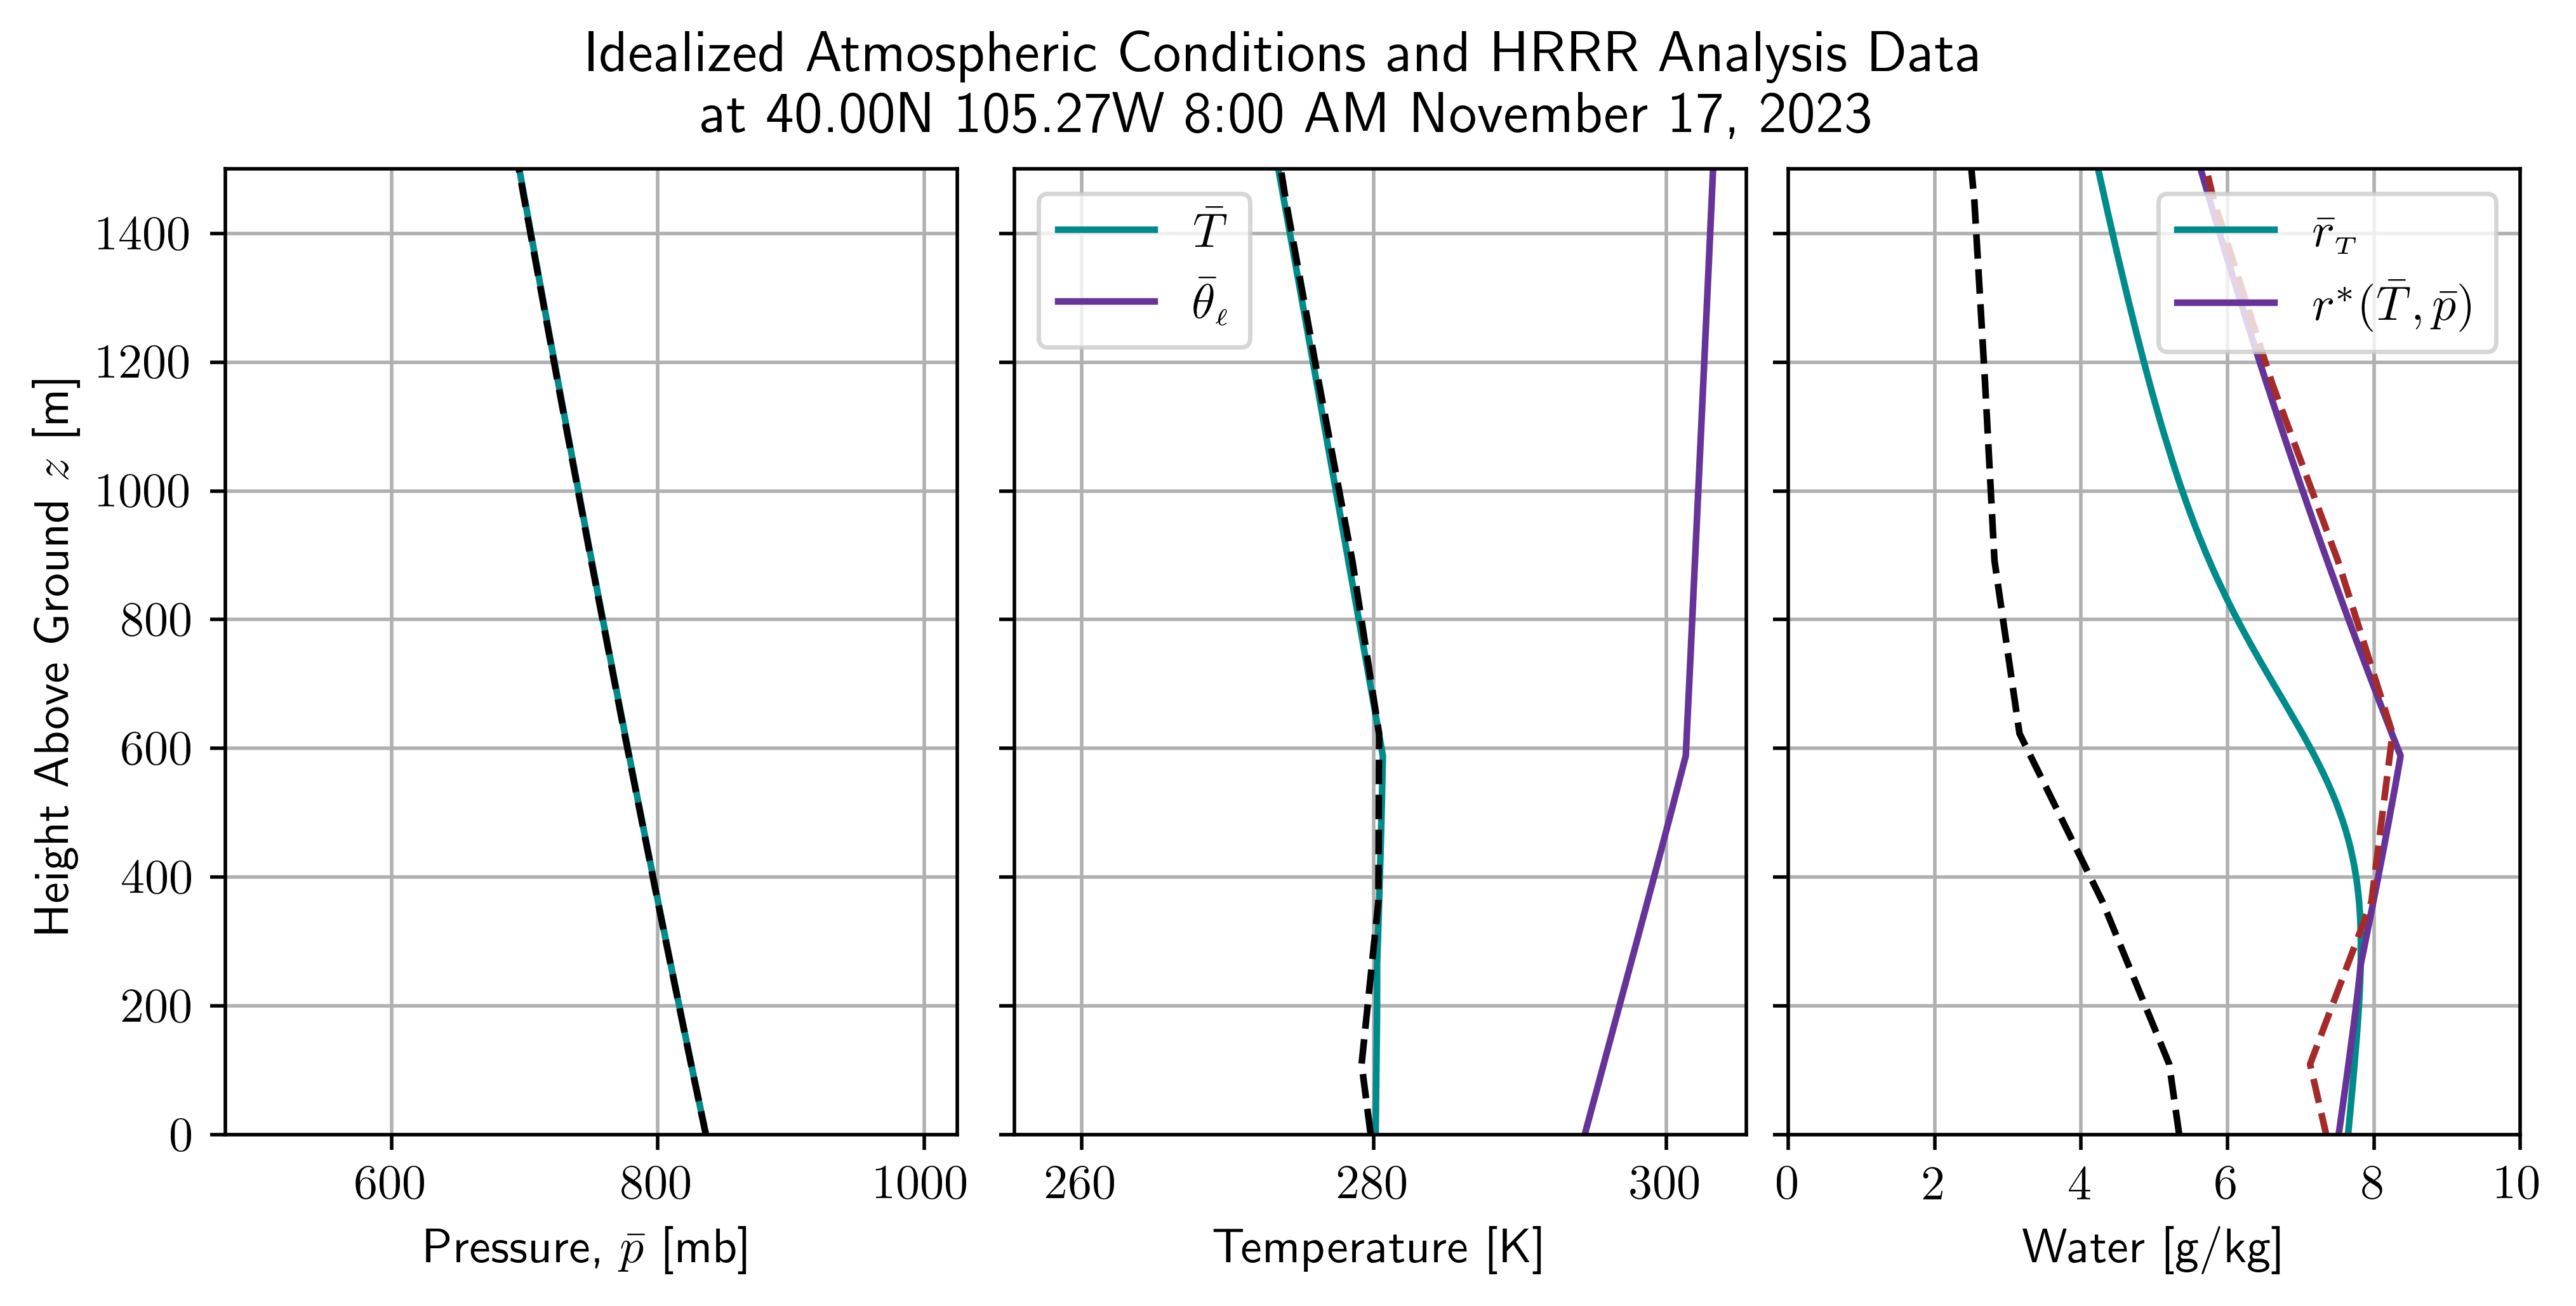

In [8]:
z_H = df['z'] - grnd
rs_H = rslf(df['p']*1e2,df['T'])
rT_H = rs_H*df['H']/100

fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(500)
fig.set_size_inches(8,4)

fig.suptitle('Idealized Atmospheric Conditions and HRRR Analysis Data\nat 40.00N 105.27W 8:00 AM November 17, 2023')

axes[0].grid()
axes[0].set_ylim(0,zf[-1])
axes[0].plot(p/100, zh, 'darkcyan')
axes[0].plot(df['p']*1e2/100, z_H, '--k')
axes[0].set(ylabel=r'Height Above Ground $z$ [m]', xlabel=r'Pressure, $\bar{p}$ [mb]')

axes[1].grid()
axes[1].plot(T, zh, 'darkcyan', label=r'$\bar{T}$')
axes[1].plot(thl, zh, color='rebeccapurple', label=r'$\bar{\theta}_{\scriptscriptstyle \ell}$')
axes[1].plot(df['T'], z_H, '--k')
axes[1].set(xlabel=r'Temperature [K]')
axes[1].legend(loc='upper left')

axes[2].grid()
axes[2].plot(rT*1000, zh, 'darkcyan', label=r'$\bar{r}_{\scriptscriptstyle T}$')
axes[2].plot(rT_H*1000, z_H, '--k')
axes[2].plot(rs*1000, zh, color='rebeccapurple', label=r'$r^*(\bar{T}, \bar{p})$')
axes[2].plot(rs_H*1000, z_H, color='brown', linestyle='--')
axes[2].set(xlabel=r'Water [g/kg]')
axes[2].set(xlim=(0,10))
axes[2].legend(loc='upper right')

plt.show()

Figure 3.2 (Presentation Version)

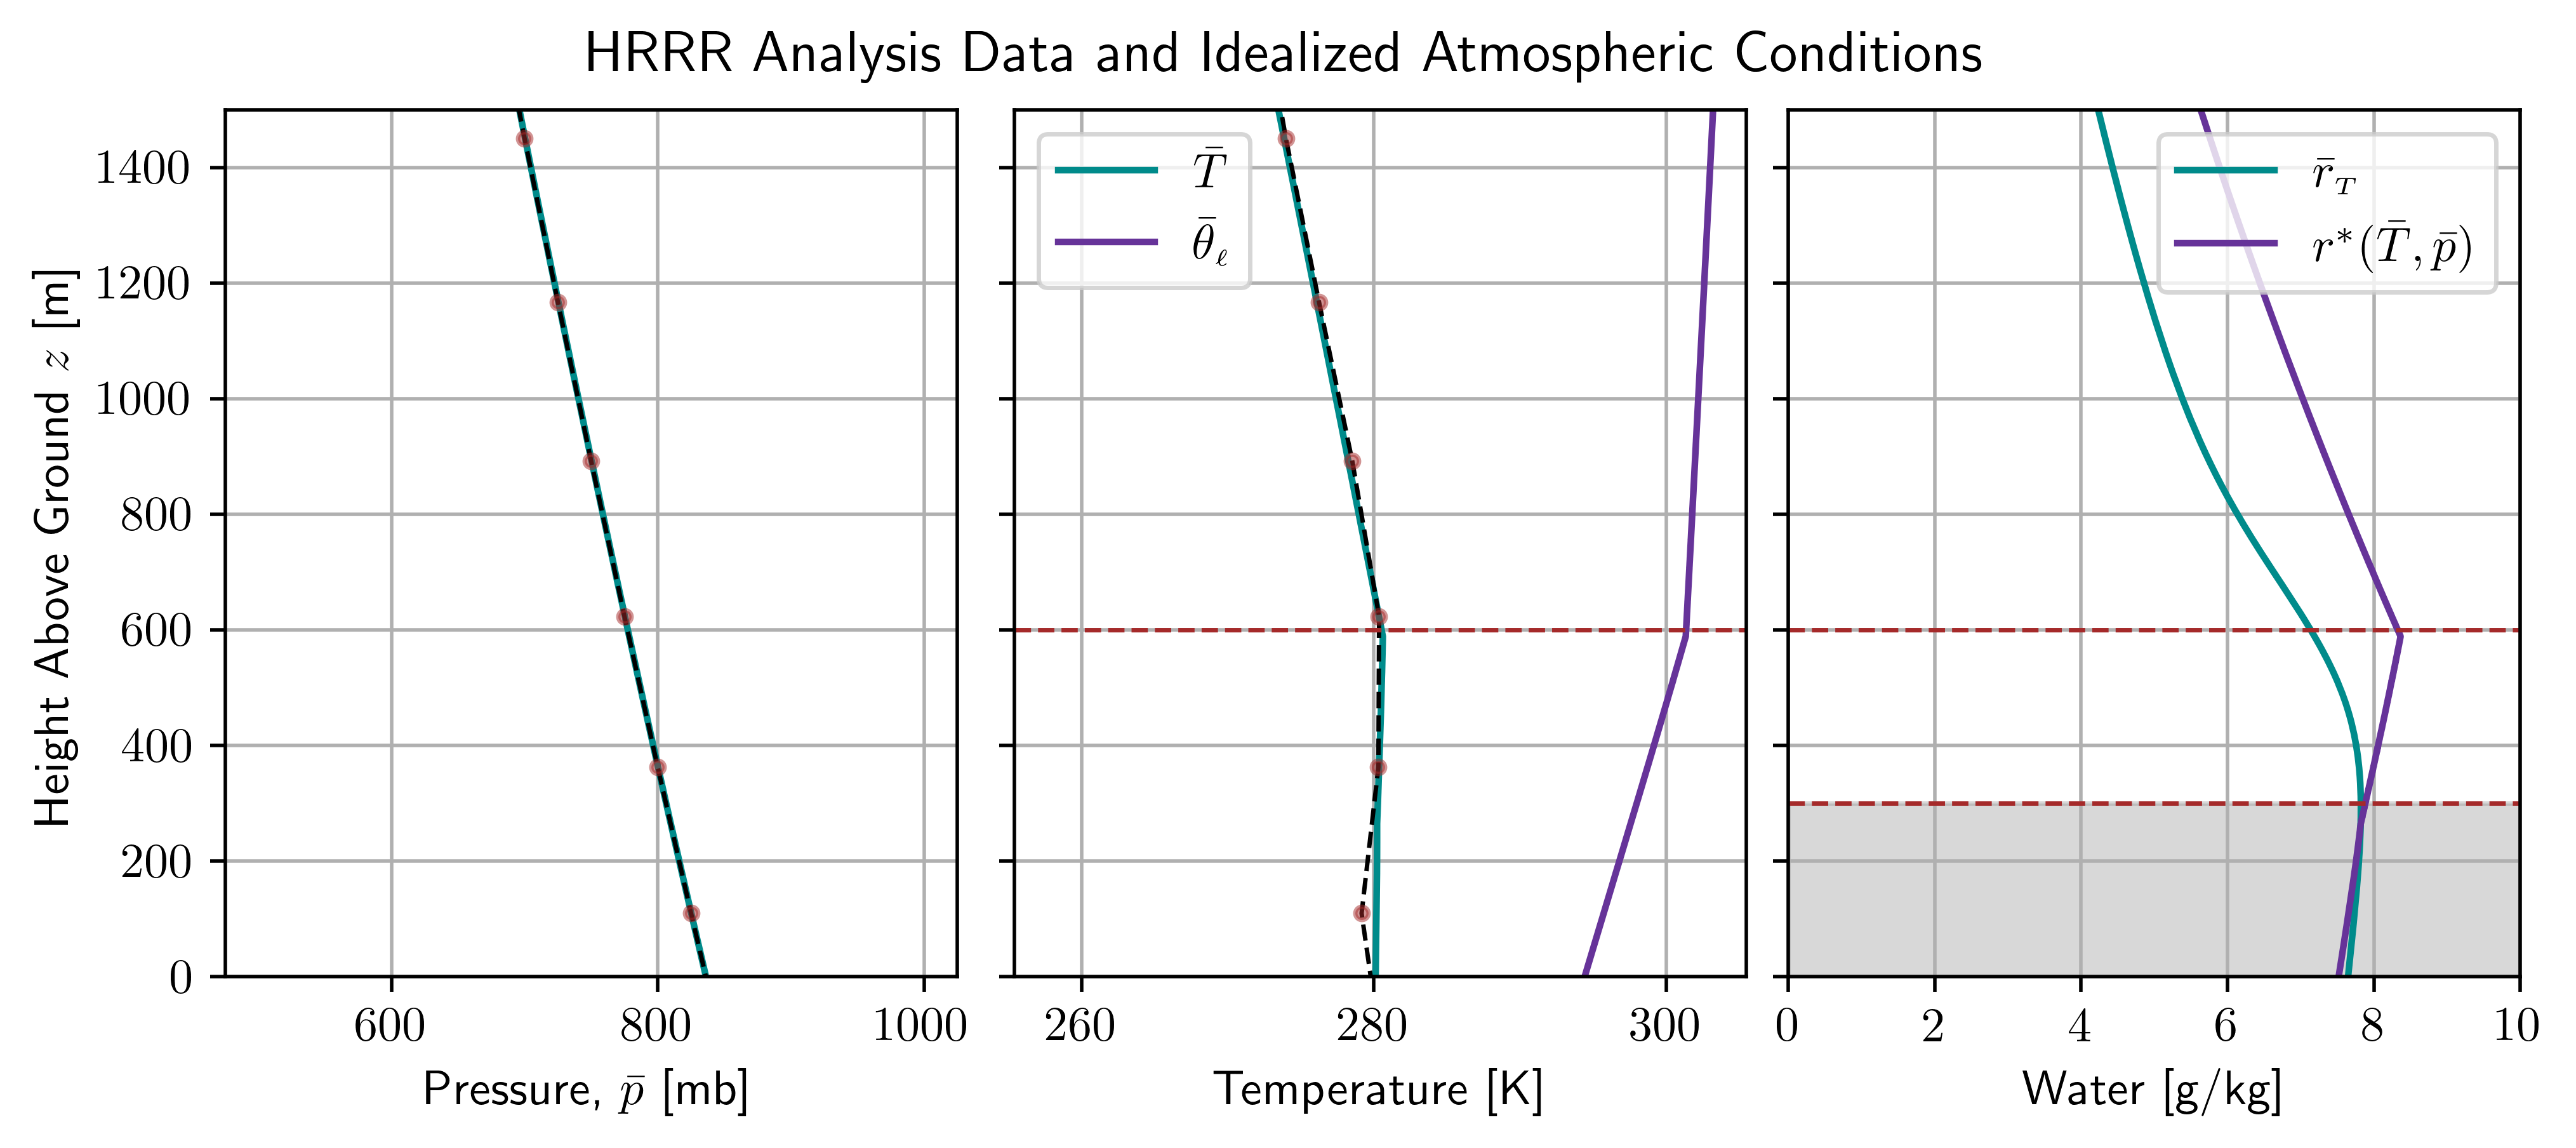

In [9]:
z_H = df['z'] - grnd
rs_H = rslf(df['p']*1e2,df['T'])
rT_H = rs_H*df['H']/100

fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(500)
fig.set_size_inches(8,3.5)

fig.suptitle('HRRR Analysis Data and Idealized Atmospheric Conditions')

axes[0].grid()
axes[0].set_ylim(0,zf[-1])
axes[0].plot(p/100, zh, 'darkcyan')
axes[0].plot(df['p']*1e2/100, z_H, '--k', linewidth=1)
axes[0].plot(df['p']*1e2/100, z_H, '.', color='brown', alpha=0.5)
axes[0].set(ylabel=r'Height Above Ground $z$ [m]', xlabel=r'Pressure, $\bar{p}$ [mb]')

axes[1].grid()
axes[1].plot(T, zh, 'darkcyan', label=r'$\bar{T}$')
axes[1].plot(thl, zh, color='rebeccapurple', label=r'$\bar{\theta}_{\scriptscriptstyle \ell}$')
axes[1].plot(df['T'], z_H, '--k', linewidth=1)
axes[1].plot(df['T'], z_H, '.', color='brown', alpha=0.5)
axes[1].axhline(600, linestyle='--', linewidth=1, color='brown')
axes[1].set(xlabel=r'Temperature [K]')
axes[1].legend(loc='upper left')

axes[2].grid()
axes[2].plot(rT*1000, zh, 'darkcyan', label=r'$\bar{r}_{\scriptscriptstyle T}$')
axes[2].plot(rs*1000, zh, color='rebeccapurple', label=r'$r^*(\bar{T}, \bar{p})$')
axes[2].set(xlabel=r'Water [g/kg]')
axes[2].fill_between((0.0,10.0), 300, 0, color='grey', alpha=0.3)
axes[2].axhline(600, linestyle='--', linewidth=1, color='brown')
axes[2].axhline(300, linestyle='--', linewidth=1, color='brown')
axes[2].set(xlim=(0,10))
axes[2].legend(loc='upper right')

plt.show()